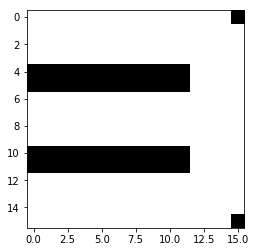

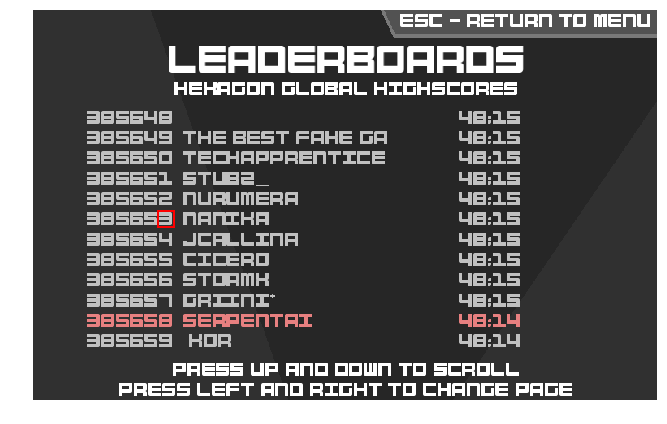

In [13]:
from IPython.display import display, clear_output

import os
import glob
import numpy as np
import skimage.io
import ipywidgets as widgets

from redis import StrictRedis

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline


redis_client = StrictRedis()

files = os.scandir("datasets/ocr/characters")
char_uuid = None


def next_character():
    clear_output(wait=True)
    file = next(files)
    
    global char_uuid
    char_uuid = file.name.split("_")[1]
    
    frame_uuid = file.name.split("_")[3]
    char_bounding_box = file.name.split("_")[4].replace(".png", "").split("-")
    char_bounding_box = [int(cbb) for cbb in char_bounding_box]
    
    redis_key = f"PROJECT_EC:CHAR:{char_uuid.upper()}"
    if redis_client.get(redis_key) is not None:
        return next_character()

    if file.is_file:
        char_image = skimage.io.imread(file.path)
    
        plt.figure()
        plt.imshow(char_image, cmap="gray")
        
        frame_image = skimage.io.imread(f"datasets/ocr/frames/frame_{frame_uuid}.png")

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(frame_image)

        y0, x0, y1, x1 = char_bounding_box
        rect = mpatches.Rectangle(
            (x0 - 2, y0 - 2), (x1 + 2) - (x0 -2), (y1 + 2) - (y0 - 2),
            fill=False, 
            edgecolor='red', 
            linewidth=2
        )
        
        ax.add_patch(rect)
        ax.set_axis_off()
        
        plt.tight_layout()
        plt.show()
    else:
        return next_character()
    
    
def on_character_submit(w):
    character = w.value
    
    redis_key = f"PROJECT_EC:CHAR:{char_uuid.upper()}"
    redis_count_key = f"PROJECT_EC:CHAR_COUNTS:{character.upper()}"
    
    redis_client.set(redis_key, character)
    
    current_count = redis_client.get(redis_count_key)
    
    if current_count is None:
        redis_client.set(redis_count_key, 1)
    else:
        current_count = int(current_count.decode("utf-8"))
        redis_client.set(redis_count_key, current_count + 1)
    
    w.value = ""
    next_character()
    
character_widget = widgets.Text(
    value="",
    placeholder="Enter the character you see...",
    description=""
)

character_widget.on_submit(on_character_submit)

display(character_widget)

next_character()

## Stats

In [14]:
total_samples = len(redis_client.keys("PROJECT_EC:CHAR:*"))
total_samples

584

In [15]:
character_count_keys = redis_client.keys("PROJECT_EC:CHAR_COUNTS*")
character_counts = list()

for character_count_key in character_count_keys:
    character_count_key = character_count_key.decode("utf-8")
    character = character_count_key.replace("PROJECT_EC:CHAR_COUNTS:", "")
    count = int(redis_client.get(character_count_key).decode("utf-8"))
    
    character_counts.append((character, count))
    
character_counts

sorted_alpha = sorted(character_counts, key=lambda cc: cc[0])
sorted_top = sorted(character_counts, key=lambda cc: cc[1], reverse=True)

print("ALPHABETICAL")
for t in sorted_alpha:
    print(f"{t[0]}: {t[1]}")

print("\nTOP")
for t in sorted_top:
    print(f"{t[0]}: {t[1]}")

ALPHABETICAL
: 3
': 1
*: 1
-: 3
0: 5
1: 23
2: 4
3: 14
4: 17
4A: 1
5: 37
6: 30
7: 9
8: 38
9: 11
:: 16
A: 27
B: 10
C: 14
D: 17
E: 34
F: 4
G: 14
H: 12
I: 28
J: 2
K: 4
L: 14
M: 10
N: 19
O: 25
P: 15
R: 36
S: 34
T: 22
U: 18
V: 2
W: 7
X: 2
Y: 1

TOP
8: 38
5: 37
R: 36
E: 34
S: 34
6: 30
I: 28
A: 27
O: 25
1: 23
T: 22
N: 19
U: 18
4: 17
D: 17
:: 16
P: 15
L: 14
3: 14
G: 14
C: 14
H: 12
9: 11
M: 10
B: 10
7: 9
W: 7
0: 5
F: 4
K: 4
2: 4
: 3
-: 3
V: 2
J: 2
X: 2
*: 1
4A: 1
Y: 1
': 1


In [17]:
def generate_labels():
    character_count_keys = redis_client.keys("PROJECT_EC:CHAR_COUNTS*")
    labels = list()
    
    for character_count_key in character_count_keys:
        character_count_key = character_count_key.decode("utf-8")
        character = character_count_key.replace("PROJECT_EC:CHAR_COUNTS:", "")

        labels.append(character) if len(character) < 2 else ""
        
    return sorted(labels)

labels = generate_labels()
labels

['',
 "'",
 '*',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

In [18]:
def generate_data_and_targets():
    character_keys = redis_client.keys("PROJECT_EC:CHAR:*")
    
    data = list()
    targets = list()
    
    for character_key in character_keys:
        character_key = character_key.decode("utf-8")
        character_uuid = character_key.split(":")[-1].lower()
        
        character_file_path = glob.glob(f"datasets/ocr/characters/char_{character_uuid}*")[0]
        
        character_image = skimage.io.imread(character_file_path, as_grey=True)
        data.append(character_image.astype(np.bool).flatten())
        
        target = redis_client.get(character_key)        
        targets.append(target.decode("utf-8"))
        
    return (data, targets)
    
data, targets = generate_data_and_targets()

In [19]:
from sklearn import svm
classifier = svm.SVC(gamma=0.001, C=100.)

classifier.fit(data[:], targets[:])

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
import pickle

serialized_classifier = pickle.dumps(classifier)

with open("datasets/ocr/super_hexagon_ocr.model", "wb") as f:
    f.write(serialized_classifier)